# LSTM with autoencoder outliner detection

https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection/blob/master/Sensor%20Anomaly%20Detection.ipynb

https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

https://machinelearningmastery.com/lstm-autoencoders/


<img src='https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_Detection_contextual_anomalies.jpg?ssl=1 ' >



link: https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_Detection_contextual_anomalies.jpg?ssl=1 

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [1]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 1.34MB/s]


In [4]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


df_reg=df
import numpy as np
csv=np.genfromtxt('spx.csv',delimiter=',')

#calc the moving average
df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()
df['index'] = range(1, len(df) + 1)

df.head()

#df.set_index("close", inplace = True)
df



,close,SMA_Temp,index
date,,,
1986-01-02,209.59,209.590000,1
1986-01-03,210.88,210.235000,2
1986-01-06,210.65,210.373333,3
1986-01-07,213.80,211.230000,4
1986-01-08,207.97,210.578000,5
...,...,...,...
2018-06-25,2717.07,2664.416800,8188
2018-06-26,2723.06,2665.724950,8189
2018-06-27,2699.63,2666.782550,8190


In [5]:
# calc std. deviation and mean
std_x_train=np.std(df["close"])
mean_x_train=np.mean(df["close"])

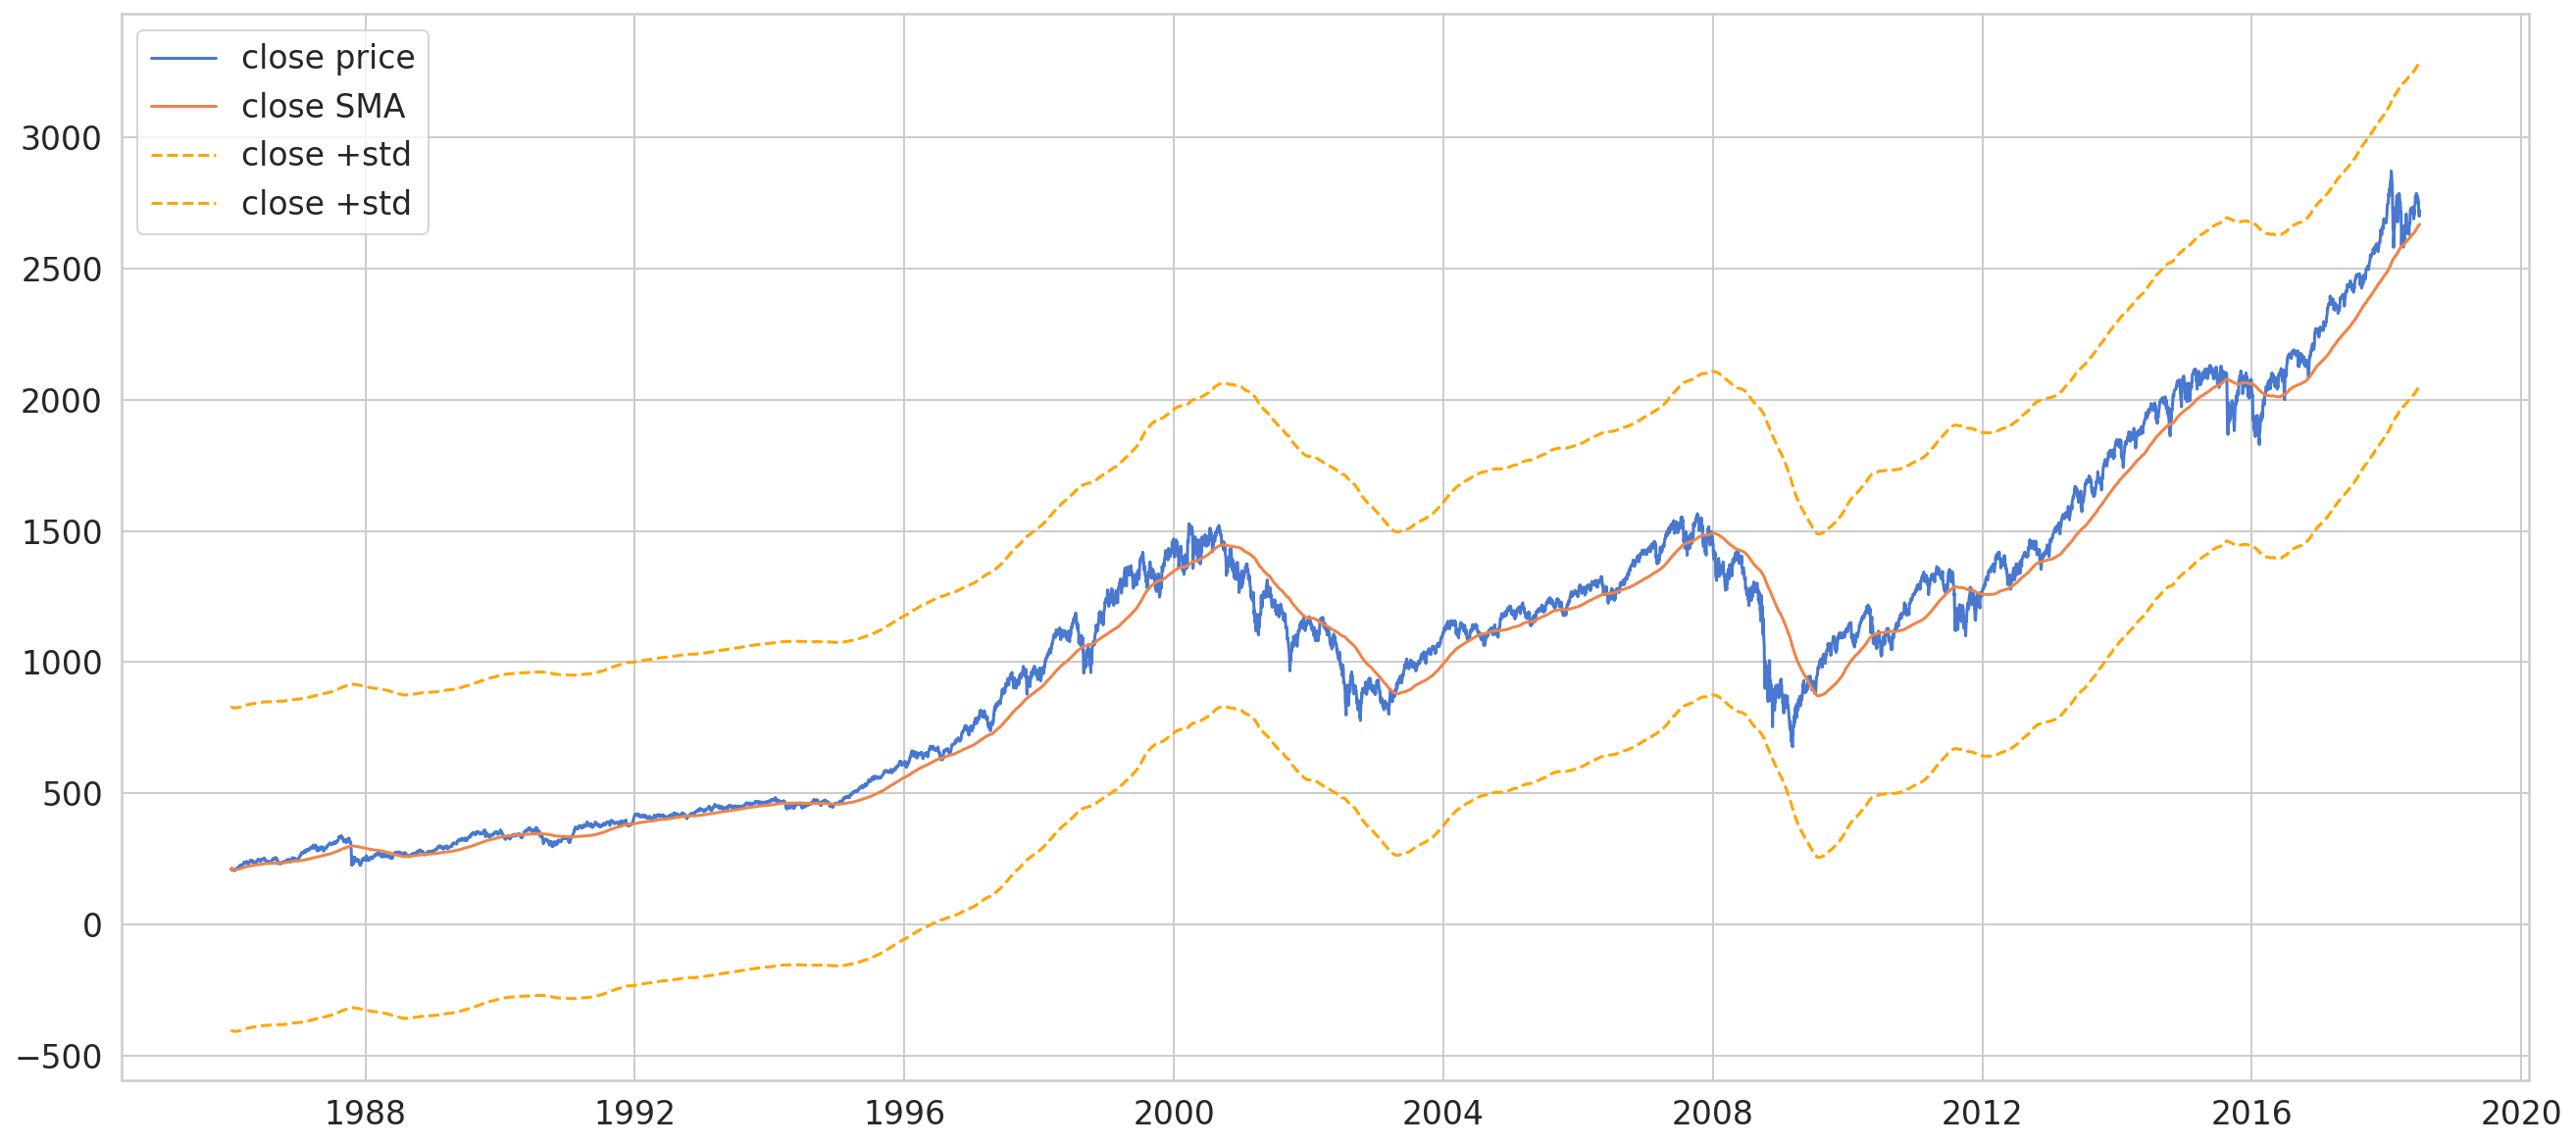

In [6]:
rcParams['figure.figsize'] = 22, 10
import matplotlib.pyplot as plt
      
plt.plot(df.index,df["close"], label='close price')
plt.plot(df.index,df["SMA_Temp"] ,label='close SMA')

plt.plot(df.index,df["SMA_Temp"]+ std_x_train,label='close +std' , color="orange",linestyle='dashed')
plt.plot(df.index,df["SMA_Temp"]- std_x_train,label='close +std', color="orange",linestyle='dashed')

plt.legend();

In [7]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 3) (1639, 3)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])



train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [9]:
# create the dataset for the timeseries and time steps

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

### look 30 days back for prediction

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)



(6523, 30, 1)


## create the model

### autoencoder and LSTM

In [13]:
X_train.shape[1]

30

In [14]:
model = keras.Sequential()

#encoder
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))


#decoder
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
184/184 [==============================] - 11s 10ms/step - loss: 0.1759 - val_loss: 0.1109
Epoch 2/20
184/184 [==============================] - 1s 7ms/step - loss: 0.1143 - val_loss: 0.0764
Epoch 3/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0966 - val_loss: 0.0645
Epoch 4/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0868 - val_loss: 0.0486
Epoch 5/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0817 - val_loss: 0.0421
Epoch 6/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0760 - val_loss: 0.0531
Epoch 7/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0737 - val_loss: 0.0383
Epoch 8/20
184/184 [==============================] - 1s 7ms/step - loss: 0.0689 - val_loss: 0.0427
Epoch 9/20
184/184 [==============================] - 1s 6ms/step - loss: 0.0691 - val_loss: 0.0547
Epoch 10/20
184/184 [==============================] - 1s 6ms/step - loss: 0.0700 - val_loss: 0.04

In [16]:
y_hat=model.predict(X_test)
y_hat.reshape(-1,30)
y_hat.shape

model.evaluate(X_test,y_test)

51/51 [==============================] - 0s 3ms/step - loss: 1.4625


1.4624742269515991

## plot the loss vs. ecpochs

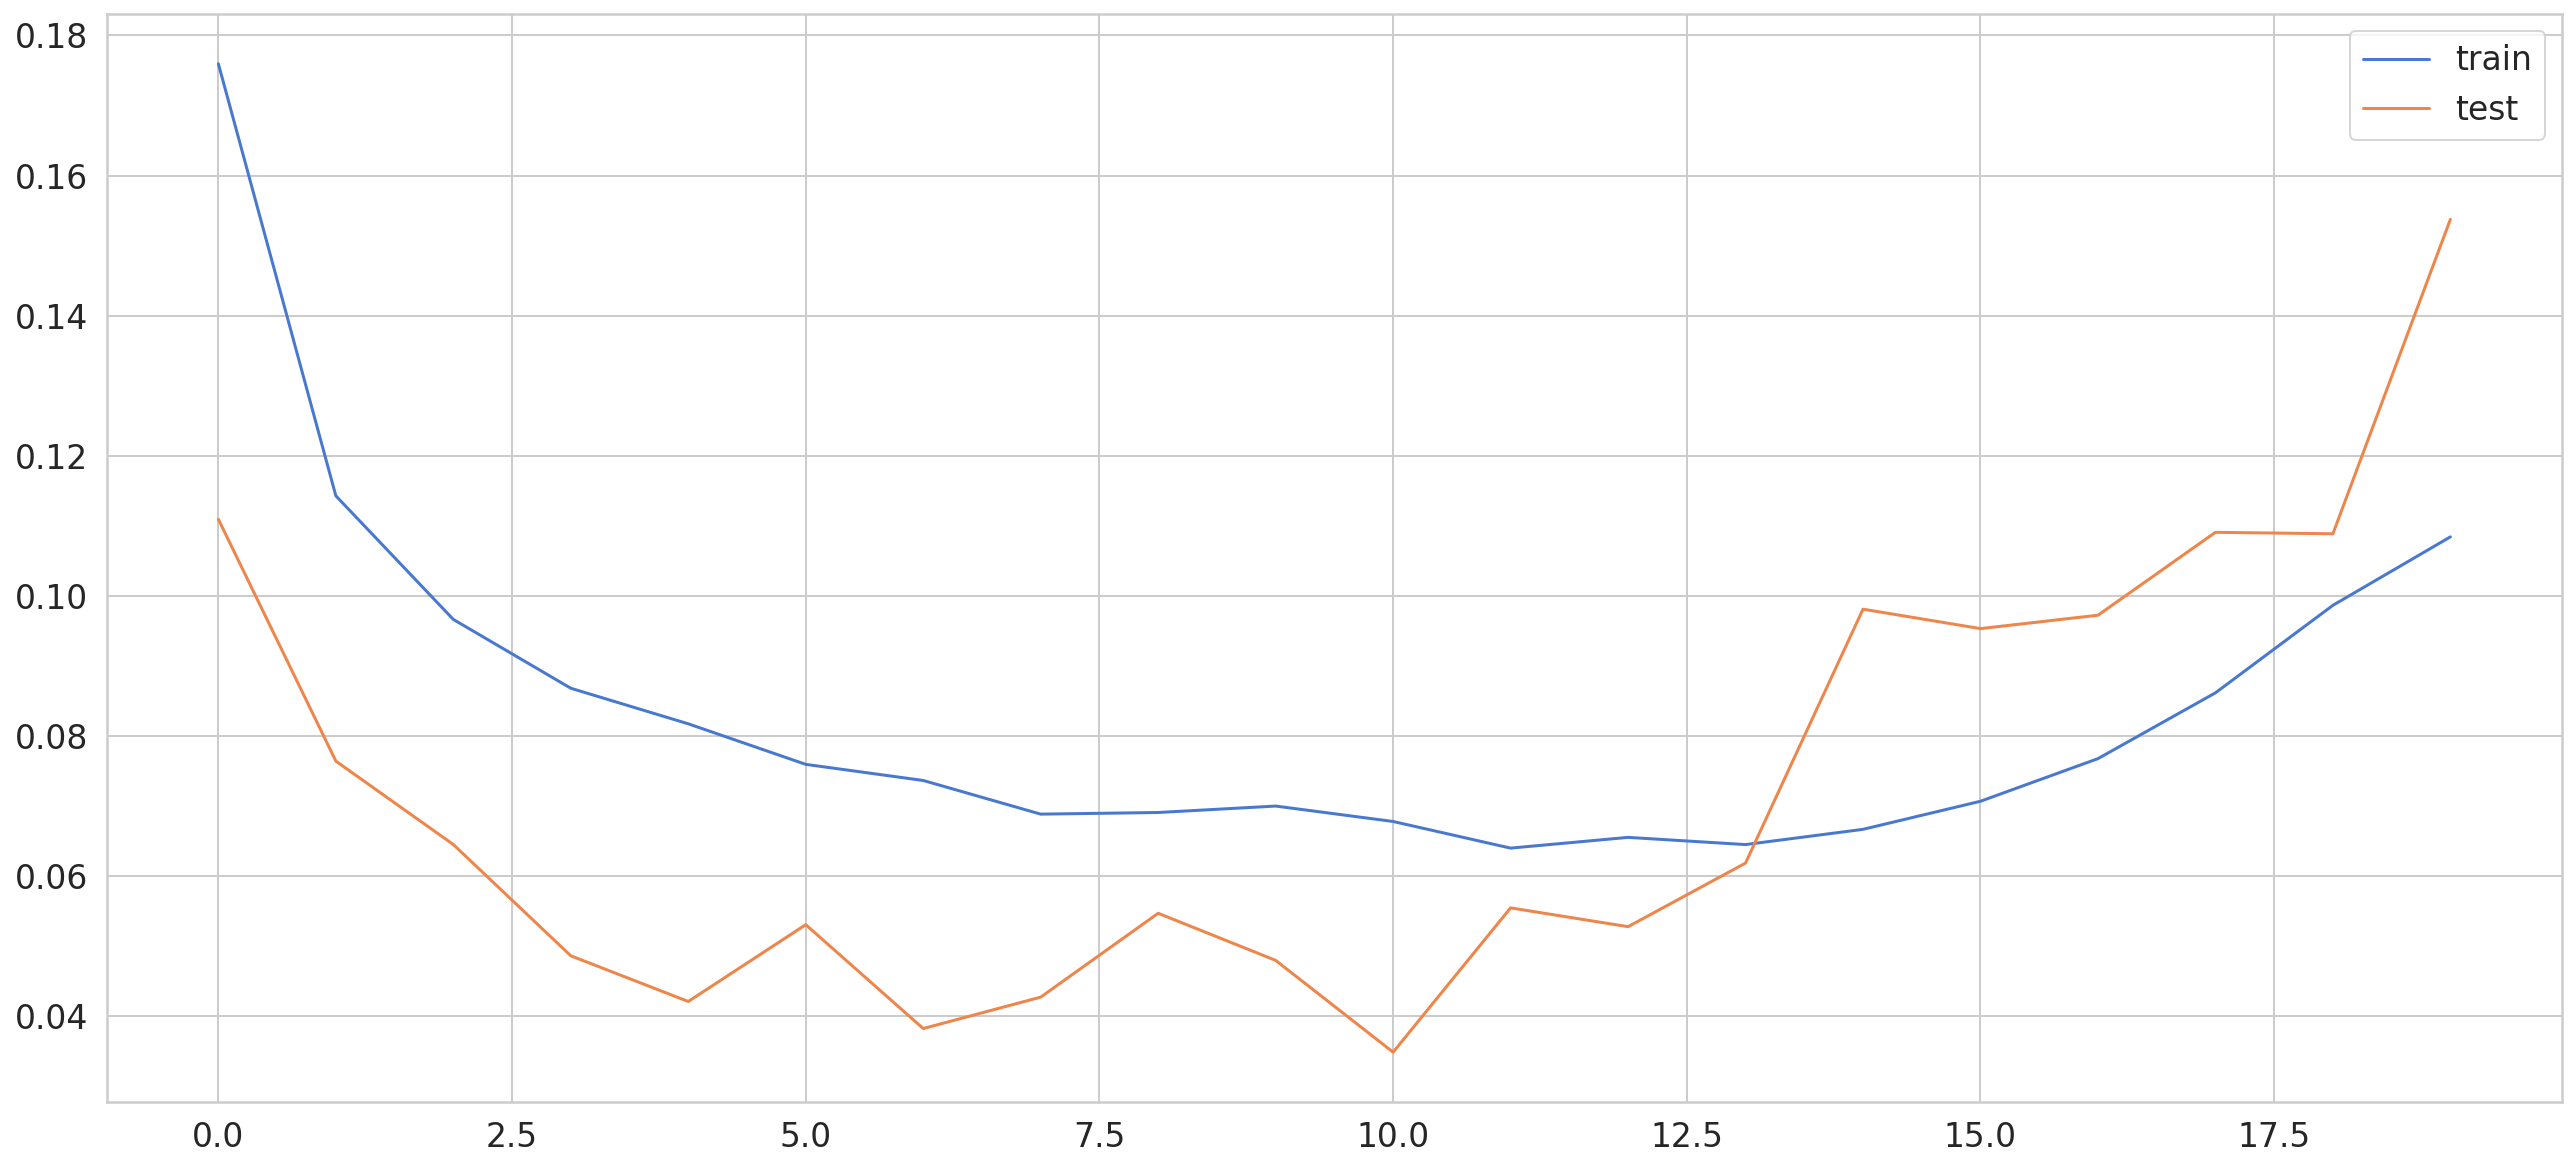

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## calc the loss between ypred - ytest

In [18]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


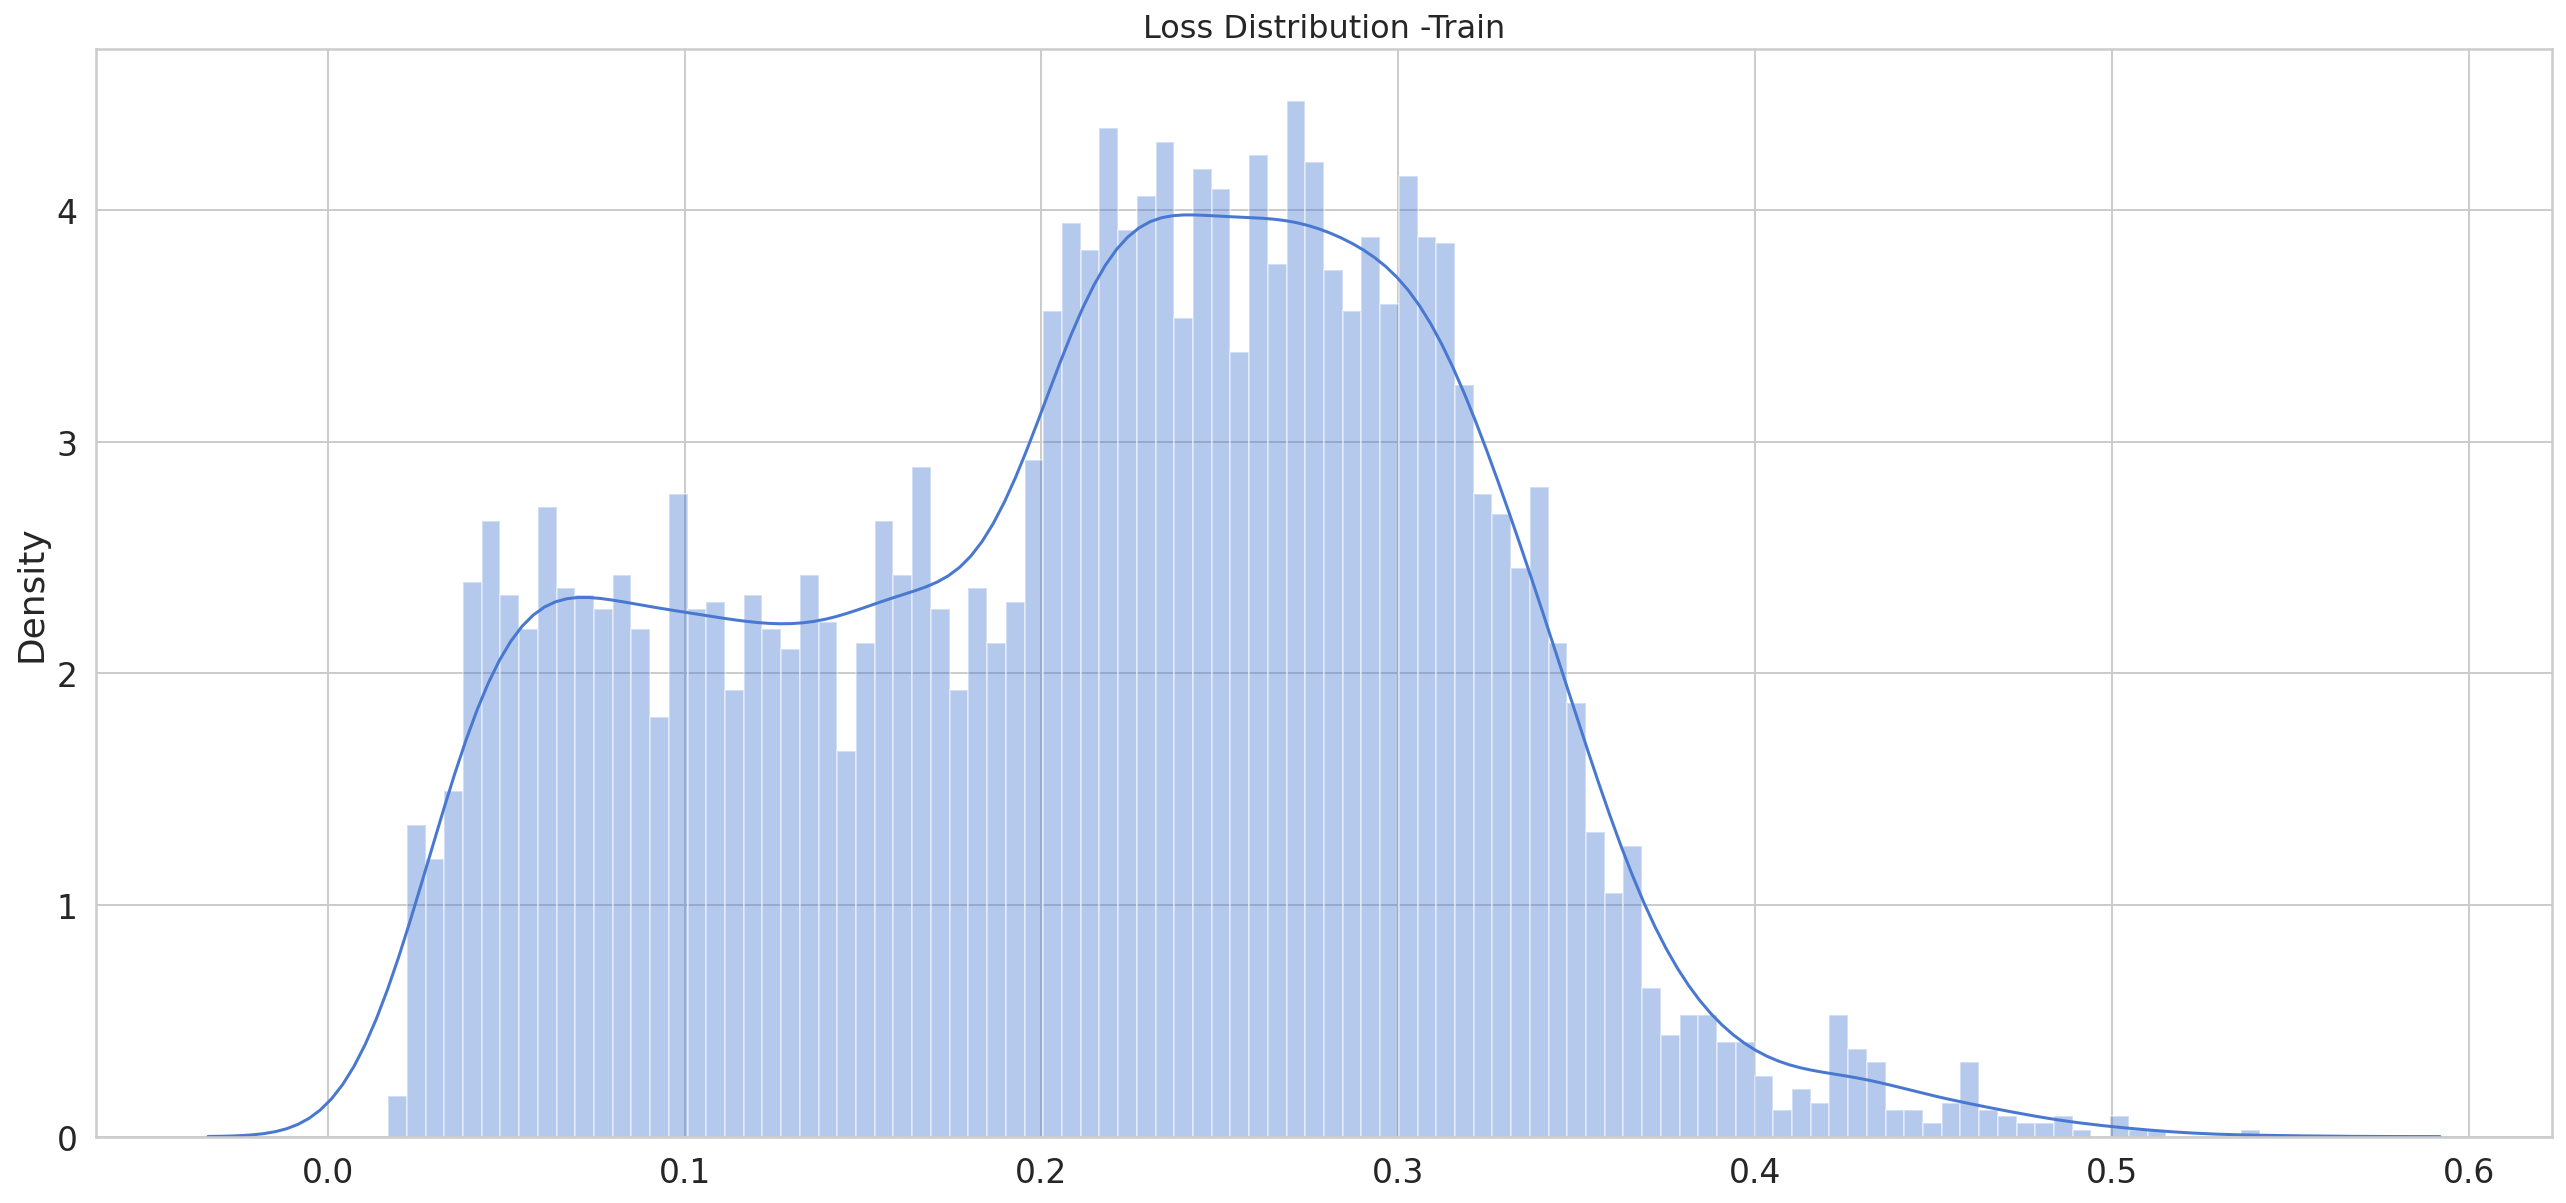

In [19]:
plt.title('Loss Distribution -Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True);

In [20]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


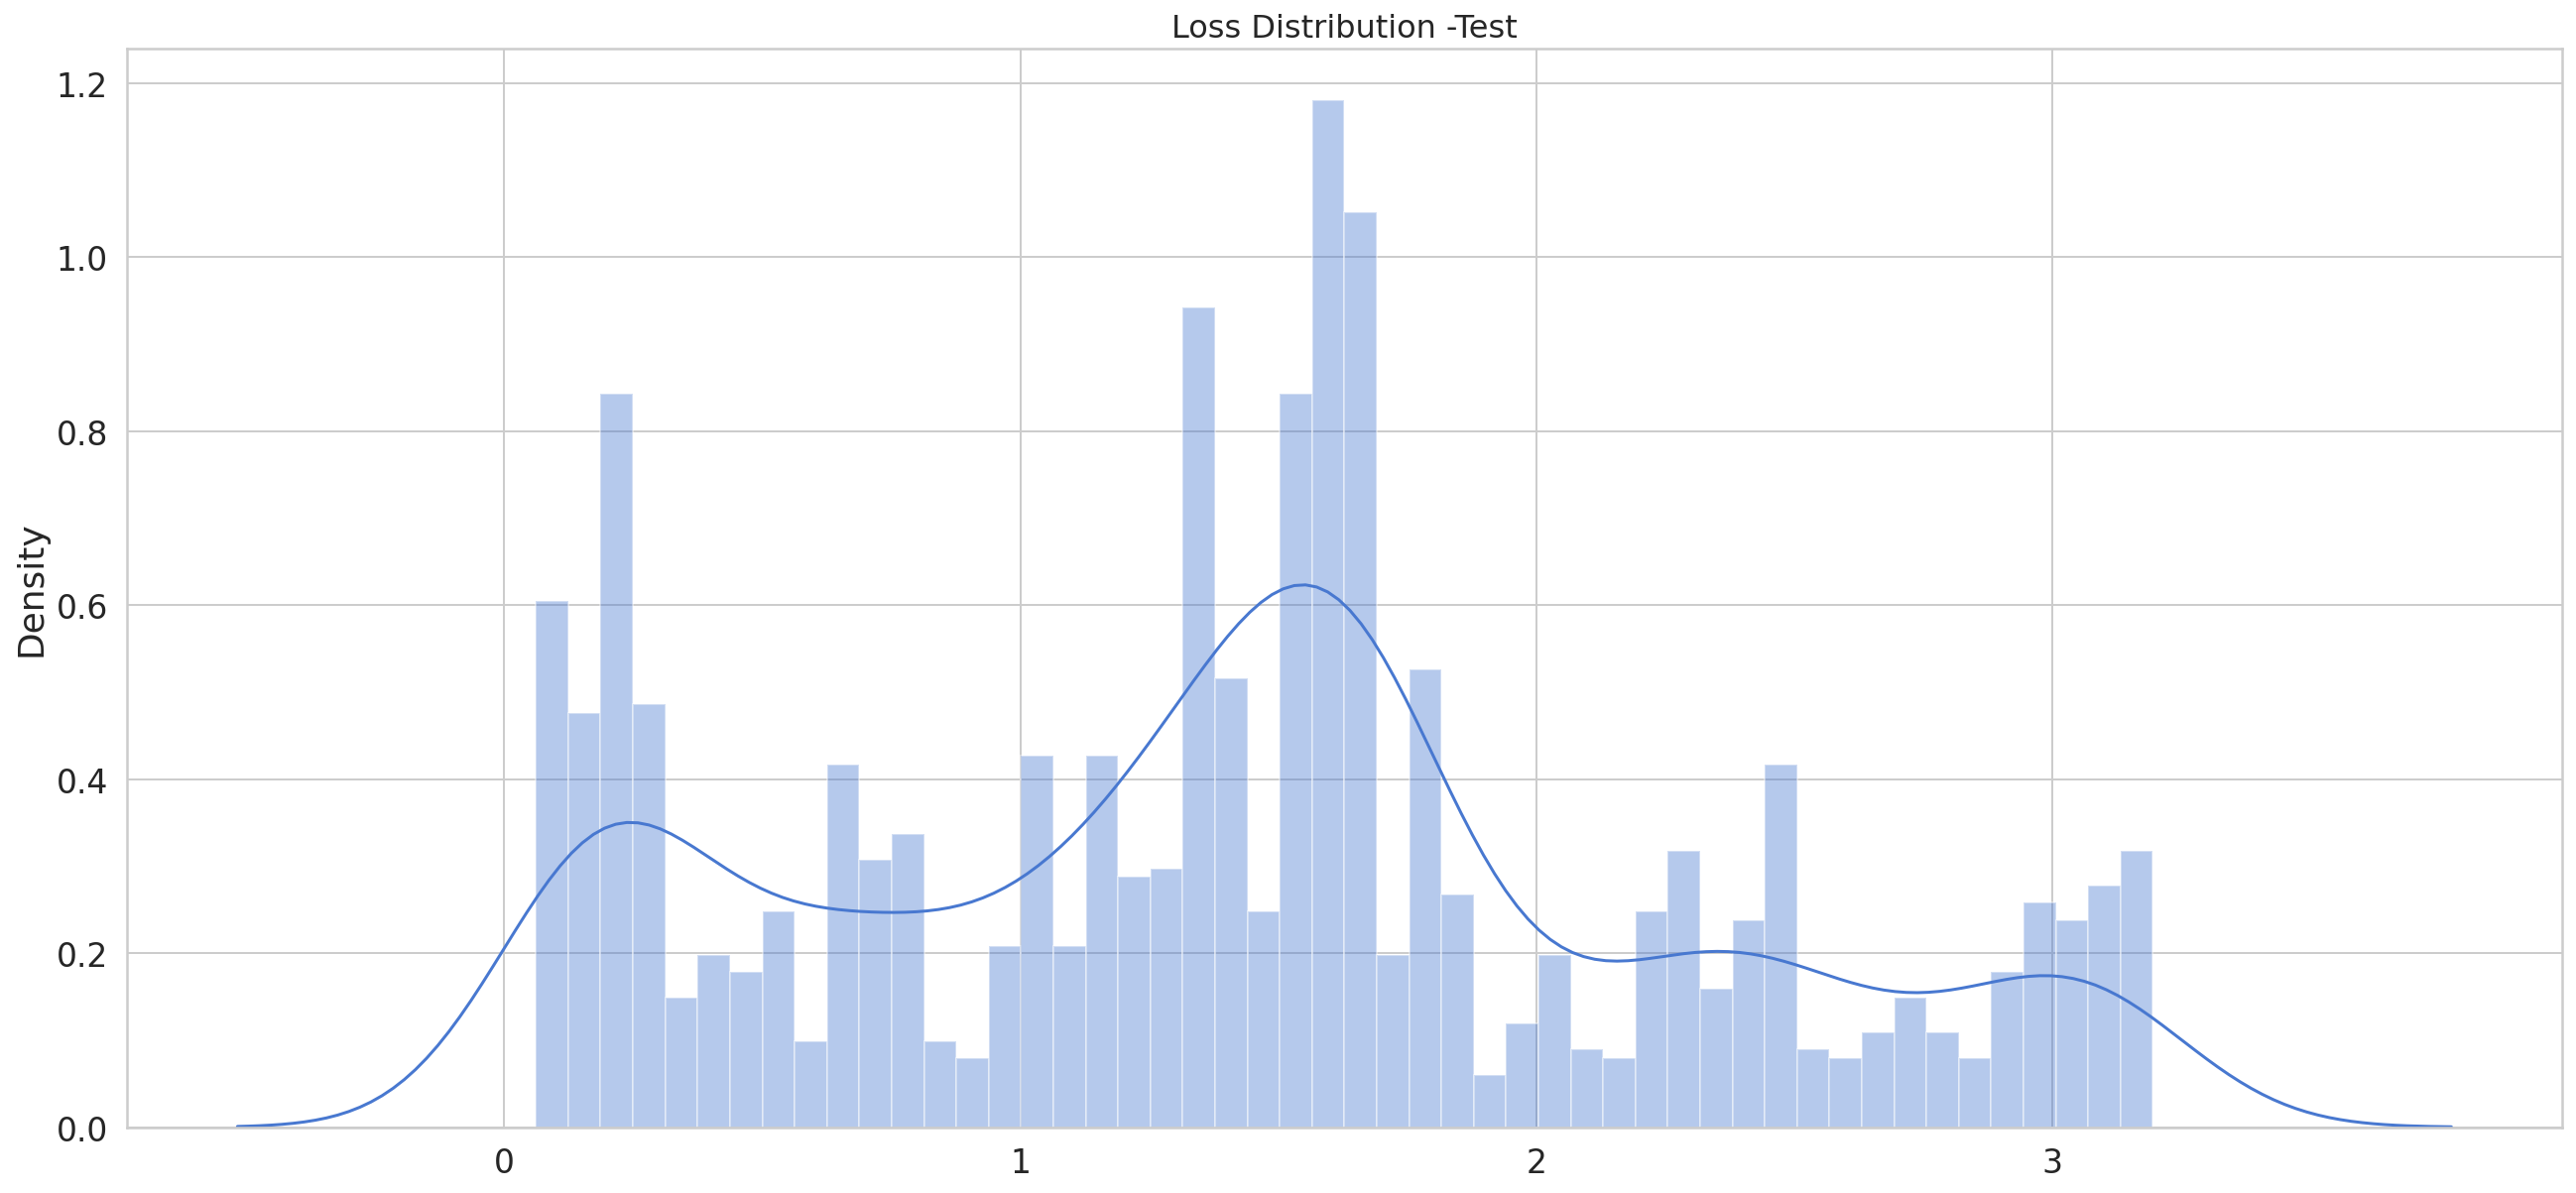

In [21]:
plt.title('Loss Distribution -Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

## calc threshold with std. deviation

In [22]:




test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss

#calculate threshold by std deviation *3

std_x_train=np.std(test_score_df.loss)*3
mean_x_train=np.mean(test_score_df.loss)

THRESHOLD = std_x_train

test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

THRESHOLD

2.53163393439657

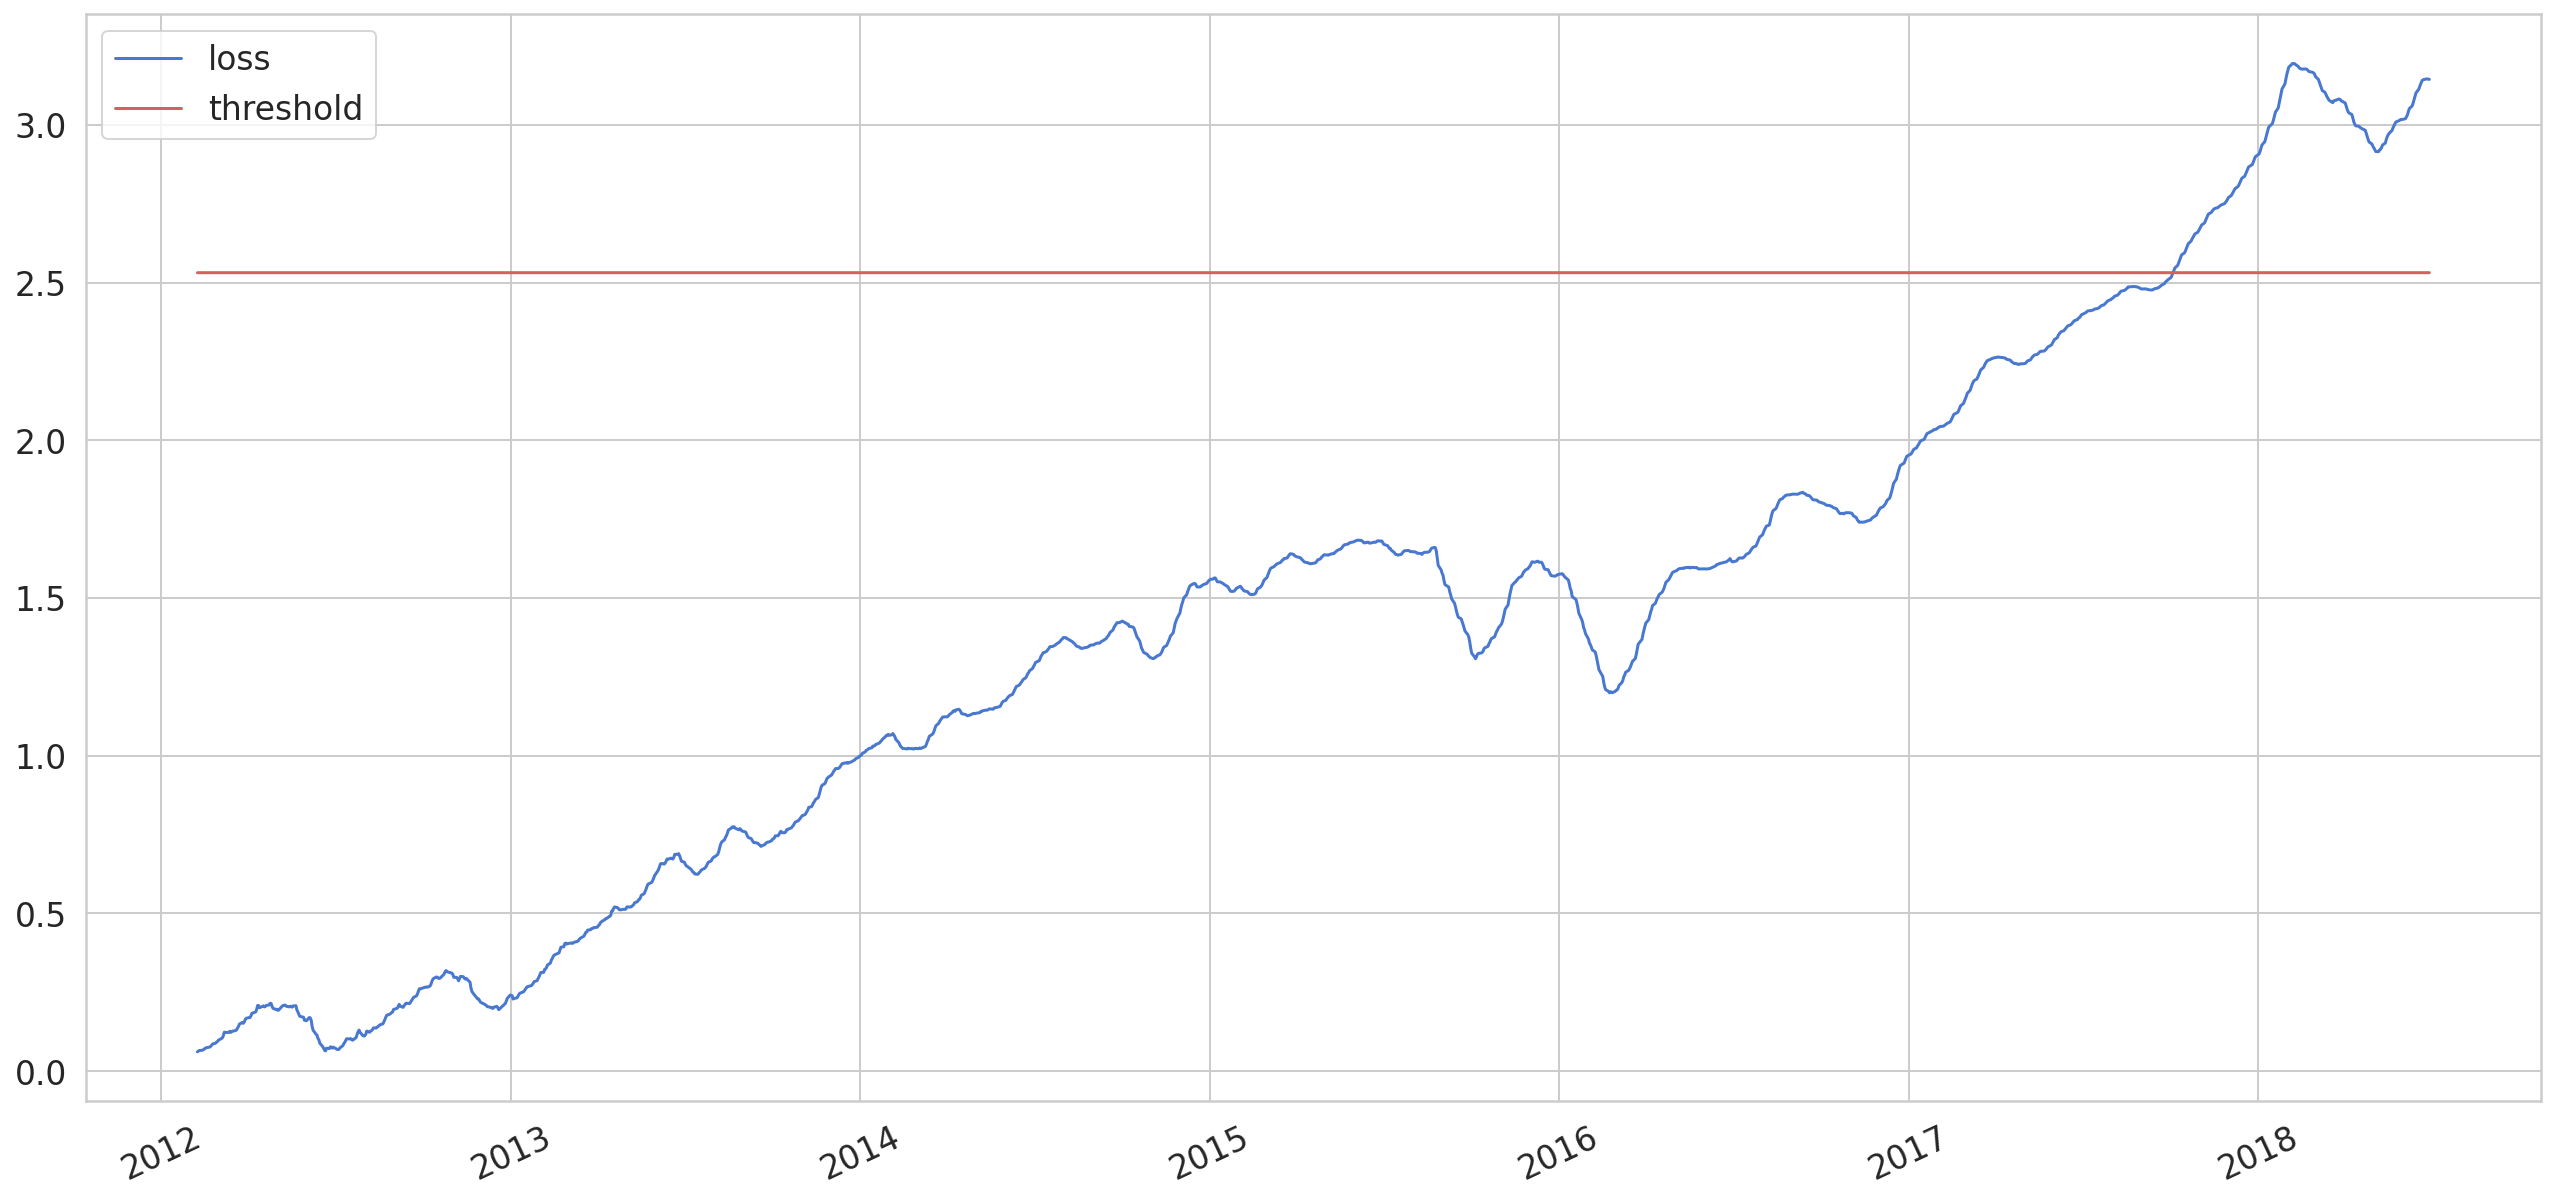

In [23]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold', color="r")
plt.xticks(rotation=25)
plt.legend();

## print and plot the anomalies

In [24]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head(30)

,loss,threshold,anomaly,close
date,,,,
2017-10-04,2.532113,2.531634,True,4.063451
2017-10-05,2.538677,2.531634,True,4.097794
2017-10-06,2.546422,2.531634,True,4.091227
2017-10-09,2.555283,2.531634,True,4.080203
2017-10-10,2.563712,2.531634,True,4.094367
2017-10-11,2.571926,2.531634,True,4.105391
2017-10-12,2.580321,2.531634,True,4.095062
2017-10-13,2.587994,2.531634,True,4.100430
2017-10-16,2.594417,2.531634,True,4.111143


In [26]:
# counting the anomalies

anomalies_str=str(anomalies.count())
anomalies_str

'loss         186\nthreshold    186\nanomaly      186\nclose        186\ndtype: int64'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


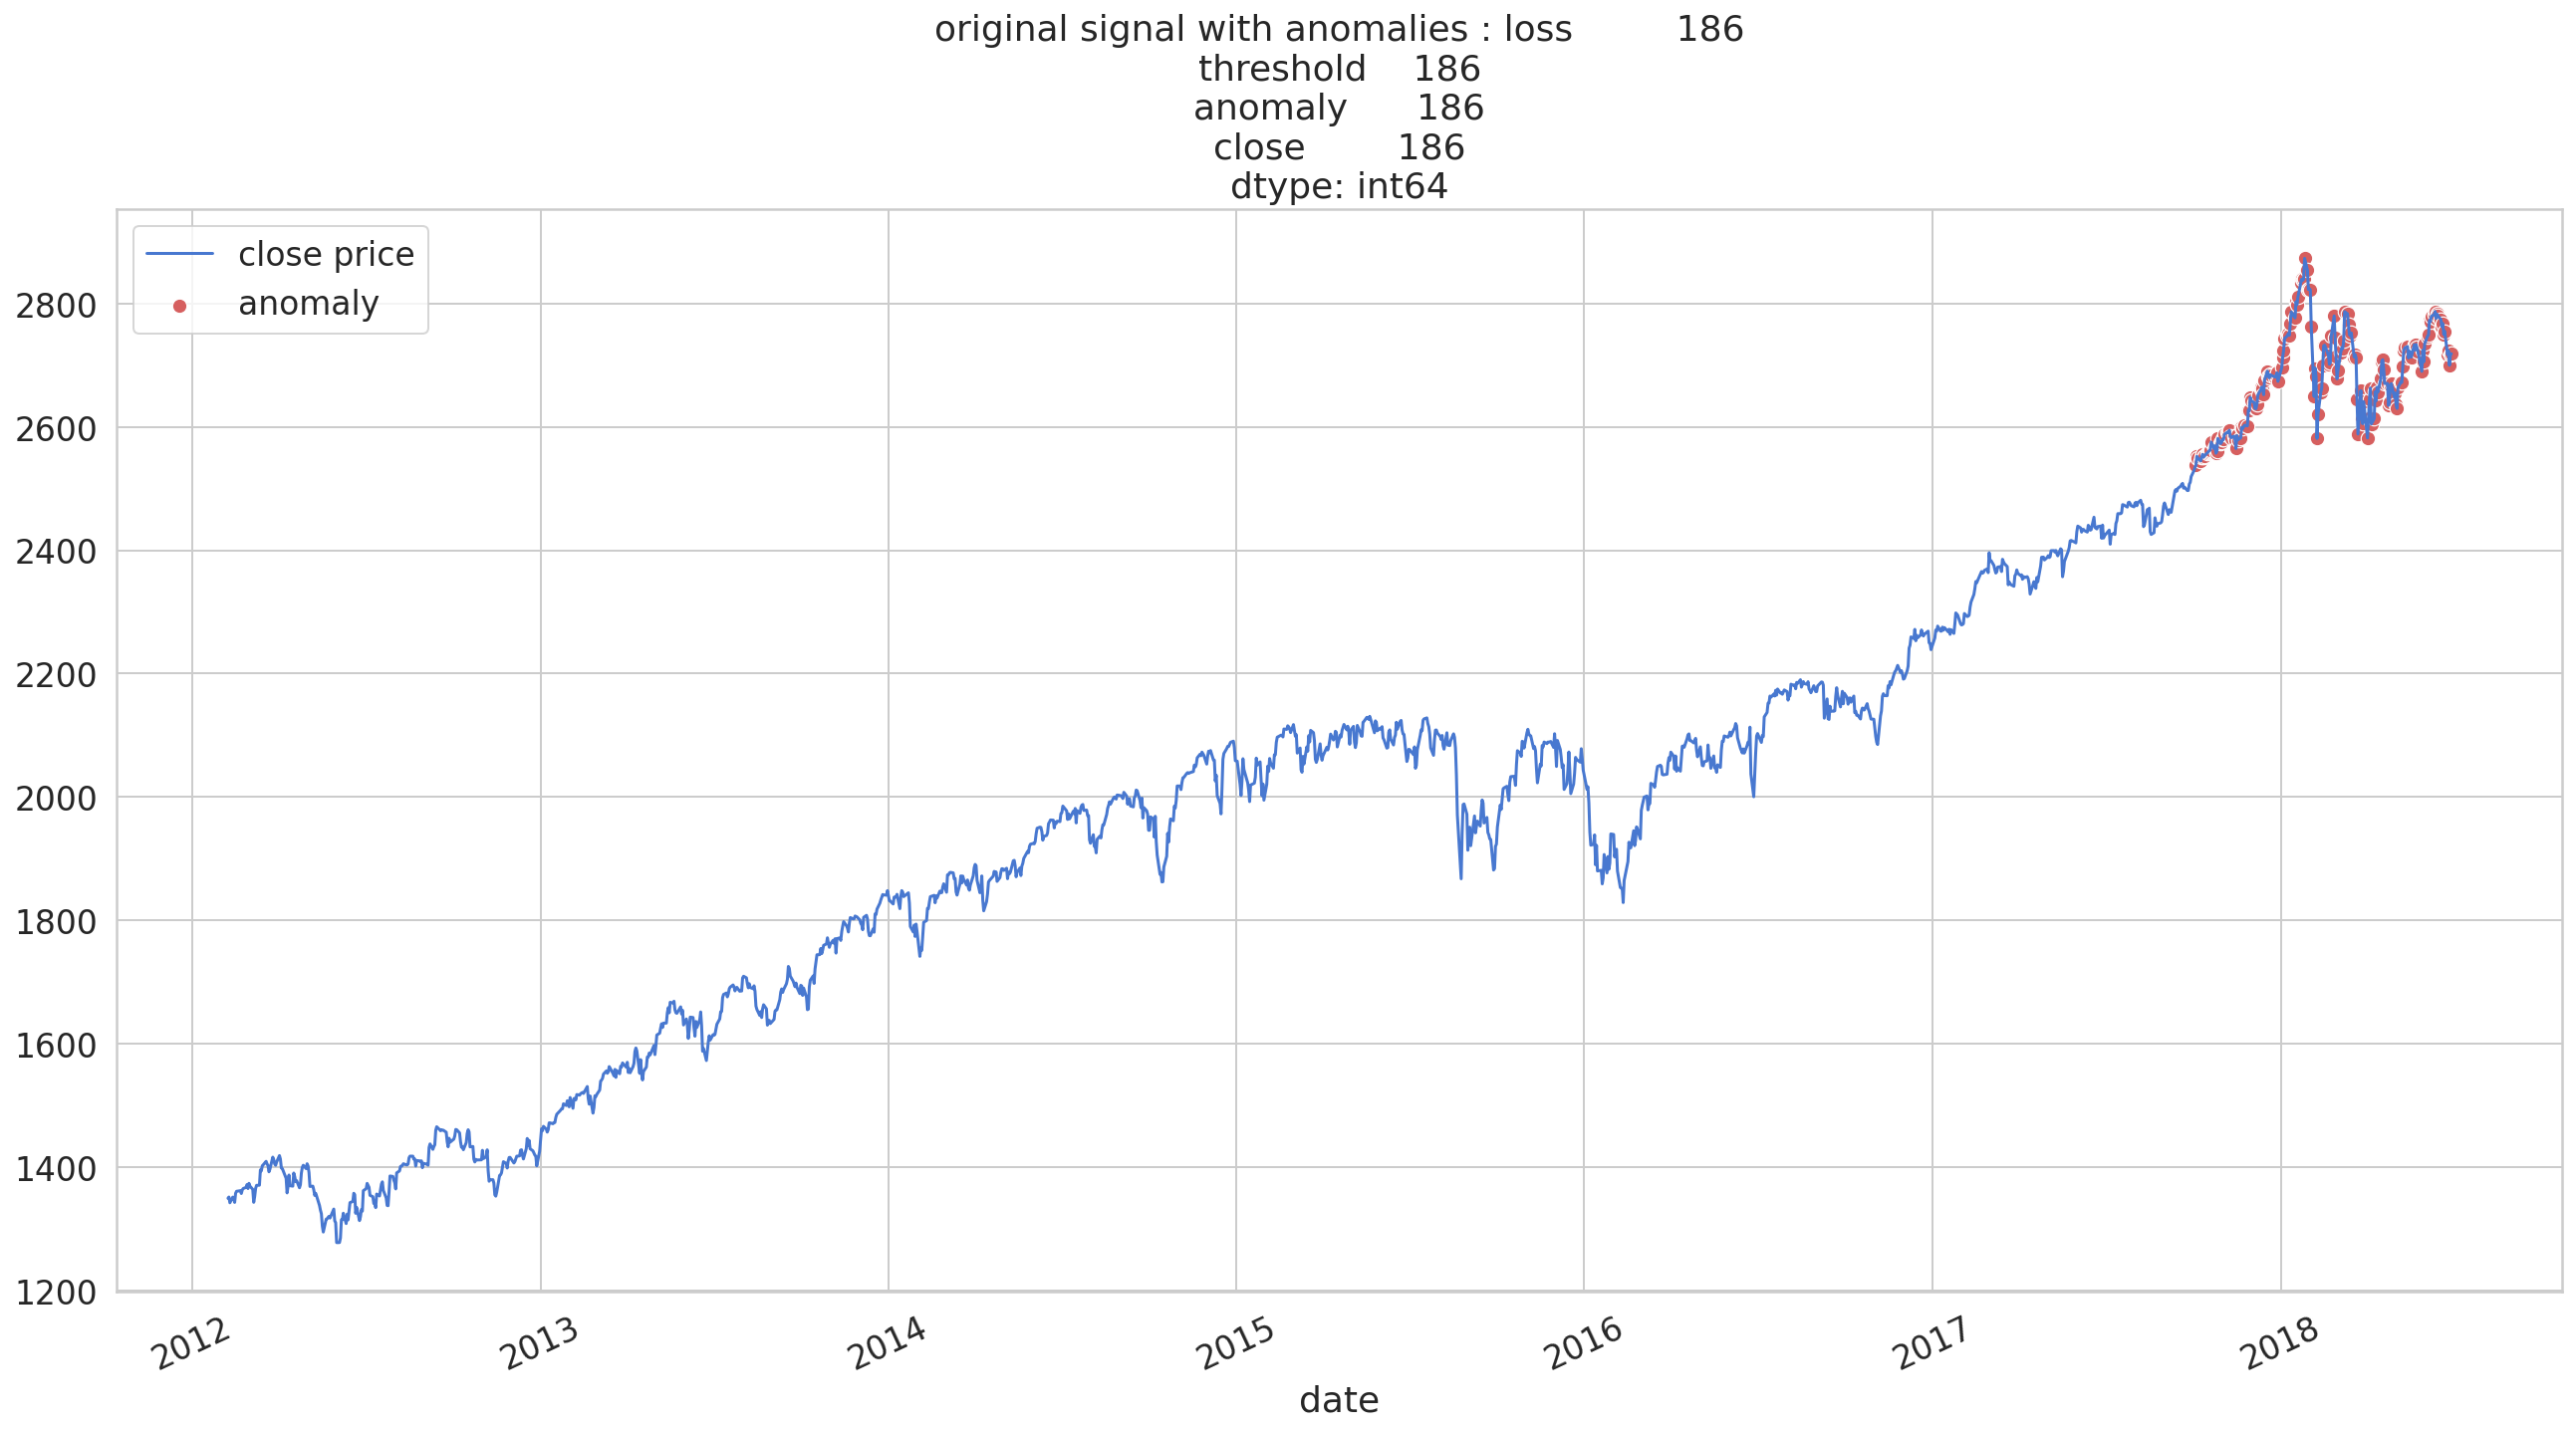

In [27]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.title('original signal with anomalies : '+anomalies_str)
plt.legend();

# Option with autokeras

In [28]:
pip install autokeras

     |████████████████████████████████| 174kB 9.5MB/s 
     |████████████████████████████████| 102kB 7.2MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=1bbae3c830aa556159e52942a806f6c11e1e6cac0307b4cda8bad577c72790aa
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
df.values.shape

(8192, 2)

In [ ]:
df2 = pd.read_csv('spx.csv')

#https://raw.githubusercontent.com/ywchiu/riii/master/data/house-prices.csv

df2.index.values



array([   0,    1,    2, ..., 8189, 8190, 8191])

In [ ]:
data = df.values
data = data.astype('float32')
y, X = data[:, :-2], data[:, -1]
#print(X.shape, y.shape)
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#X.shape
y.shape

(8192, 1)

In [ ]:
df = pd.read_csv('spx.csv')

#https://raw.githubusercontent.com/ywchiu/riii/master/data/house-prices.csv
df_reg=df
import numpy as np
csv=np.genfromtxt('spx.csv',delimiter=',')

#calc the moving average
#df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()
df['index'] = range(1, len(df) + 1)
df.drop('date',axis=1, inplace=True)
df.head()

#df.set_index("close", inplace = True)
df


,close,index
0,209.59,1
1,210.88,2
2,210.65,3
3,213.80,4
4,207.97,5
...,...,...
8187,2717.07,8188
8188,2723.06,8189
8189,2699.63,8190
8190,2716.31,8191


In [ ]:
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/auto-insurance.csv'
dataframe = read_csv(url, header=None)
print(dataframe.shape)
# split into input and output elements
data = dataframe.values
data = data.astype('float32')
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#X.shape
dataframe

(63, 2)
(63, 1) (63,)
(42, 1) (21, 1) (42,) (21,)


,0,1
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4
...,...,...
58,9,87.4
59,31,209.8
60,14,95.5
61,53,244.6


In [ ]:
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/auto-insurance.csv'
dataframe = read_csv(url, header=None)
print(dataframe.shape)
# split into input and output elements
data = df.values
data = data.astype('float32')
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

df

(63, 2)
(8192, 1) (8192,)
(5488, 1) (2704, 1) (5488,) (2704,)


,close,index
0,209.59,1
1,210.88,2
2,210.65,3
3,213.80,4
4,207.97,5
...,...,...
8187,2717.07,8188
8188,2723.06,8189
8189,2699.63,8190
8190,2716.31,8191


In [ ]:


# define the search
model = StructuredDataRegressor(max_trials=3, loss='mean_absolute_error')
# perform the search
model.fit(x=X_train, y=y_train, verbose=1)
# evaluate the model
mae, _ = model.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)
# use the model to make a prediction
X_new = asarray([[108]]).astype('float32')
yhat = model.predict(X_new)
print('Predicted: %.3f' % yhat[0])
# get the best performing model
model = model.export_model()
# summarize the loaded model
model.summary()
# save the best performing model to file
#model.save('model_insurance.h5')

INFO:tensorflow:Reloading Oracle from existing project ./structured_data_regressor/oracle.json
INFO:tensorflow:Reloading Tuner from ./structured_data_regressor/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/112
172/172 [==============================] - 1s 3ms/step - loss: 2410.4033 - mean_squared_error: 9945834.0000
Epoch 2/112
172/172 [==============================] - 1s 3ms/step - loss: 733.0646 - mean_squared_error: 981300.8125
Epoch 3/112
172/172 [==============================] - 1s 3ms/step - loss: 733.5021 - mean_squared_error: 982303.4375
Epoch 4/112
172/172 [==============================] - 1s 3ms/step - loss: 733.5909 - mean_squared_error: 982613.1875
Epoch 5/112
172/172 [==============================] - 1s 3ms/step - loss: 733.5261 - mean_squared_error: 982504.8750
Epoch 6/112
172/172 [==============================] - 1s 3ms/step - loss: 733.7900 - mean_squared_error: 983684.3125
Epoch 7/112
172/172 [==============================] - 1s 3ms/step - loss: 733.6

## evaluate the model

In [ ]:
score = model.evaluate(X_test, y_test)
print(score)

85/85 [==============================] - 0s 2ms/step - loss: 720.5781 - mean_squared_error: 945462.9375
[720.578125, 945462.9375]
